In [1]:
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize': 'xx-large',
         'xtick.labelsize': 'x-large',
         'ytick.labelsize': 'x-large',
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import h5py
import numpy as np
import sys

sys.path.insert(1, '../code')
from featurize_and_fit import Featurizer, Fitter
import scalars

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = False
plot_dir = '../plots/plots_2021-01-28'

# r_edges (TNG50-4: L=35 Mpc/h, N_part=270^3, mean interparticle spacing = 35/270 = 0.13 Mpc/h = 130 kpc/h)

r_edges = np.array([0, 1])
r_units = 'r200'
print(r_edges)

m_order_max_arr = [1, 2, 3]
x_order_max = 0 # for scalars, only 0 or 2 x orders

l_arr = scalars.get_needed_ls_scalars(np.max(m_order_max_arr), x_order_max)

logy = False
unc_tag = '_unc0.1M'
runit_tag = '_r200edges'
y_scalar_feature_name='mass_hydro_subhalo_star'
y_tag = '_msubhalo'

logy_tag = ''
if logy:
    logy_tag = '_logy'

[0 1]


In [3]:
mass_multiplier = 1e10

In [4]:
featurizer = Featurizer(r_edges, r_units=r_units)
featurizer.read_simulations()
featurizer.match_twins()
featurizer.select_halos()
featurizer.add_info_to_halo_dicts()
featurizer.set_y_labels(y_scalar_feature_name='mass_hydro_subhalo_star')

In [5]:
print(featurizer.N_halos)

2344


In [6]:
featurizer.compute_geometric_features(l_arr)

uncertainties = 0.1*featurizer.y_scalar # uncertainties are 0.1*M_stellar (M_stellar is our label)

In [11]:
def plot_pred_vs_true(y_true, y_pred, y_train, y_train_pred, 
                      fitter, msfe_test, chi2_train, save_fn=None):
    fig = plt.figure(figsize=(6,6))
    ax = plt.gca()

    # main scatter plotting
    plt.scatter(y_train, y_train_pred, s=12, alpha=0.3, c='m', label='training')
    plt.scatter(y_true, y_pred, s=12, alpha=0.6, c='k', label='testing')


    # get limits, plot true line
    m_minmin = min(min(y_true[np.where(y_true > 0)]), 
                   min(y_pred[np.where(y_pred > 0)]))
    m_maxmax = max(max(y_true[np.where(y_true > 0)]), 
                   max(y_pred[np.where(y_pred > 0)]))
    true_line = np.linspace(0.5*m_minmin, 2*m_maxmax)
    plt.plot(true_line, true_line, color='grey', zorder=0)

    # labels & adjustments
    plt.xlabel(r'$m_\mathrm{true}$')
    plt.ylabel(r'$m_\mathrm{pred}$')
    plt.xscale('log')
    plt.yscale('log')
    ax.set_aspect('equal')
    plt.xlim(0.5*m_minmin, 2*m_maxmax)
    plt.ylim(0.5*m_minmin, 2*m_maxmax)

    n_neg = len(np.where(fitter.y_scalar_pred*mass_multiplier < 0)[0])
    plt.text(0.1, 0.9, fr'$n_\mathrm{{features}}$: {fitter.n_features}, rank: {fitter.res_scalar[2]}' '\n'
                       fr'MSFE: {msfe_test:.3e}, $n_\mathrm{{test}}$: {fitter.n_test}' '\n'
                       fr'$\chi^2$: {chi2_train:.3e}, $n_\mathrm{{train}}$: {fitter.n_train}' '\n'
                       fr'# m_pred < 0: {n_neg}', 
             transform=ax.transAxes, verticalalignment='top', fontsize=12)
    plt.title(save_tag)
    plt.legend(loc='center left', fontsize=14)

    # save
    if save_fn is not None and save_plots:
          plt.savefig(f"{plot_dir}/{save_fn}", bbox_inches='tight')

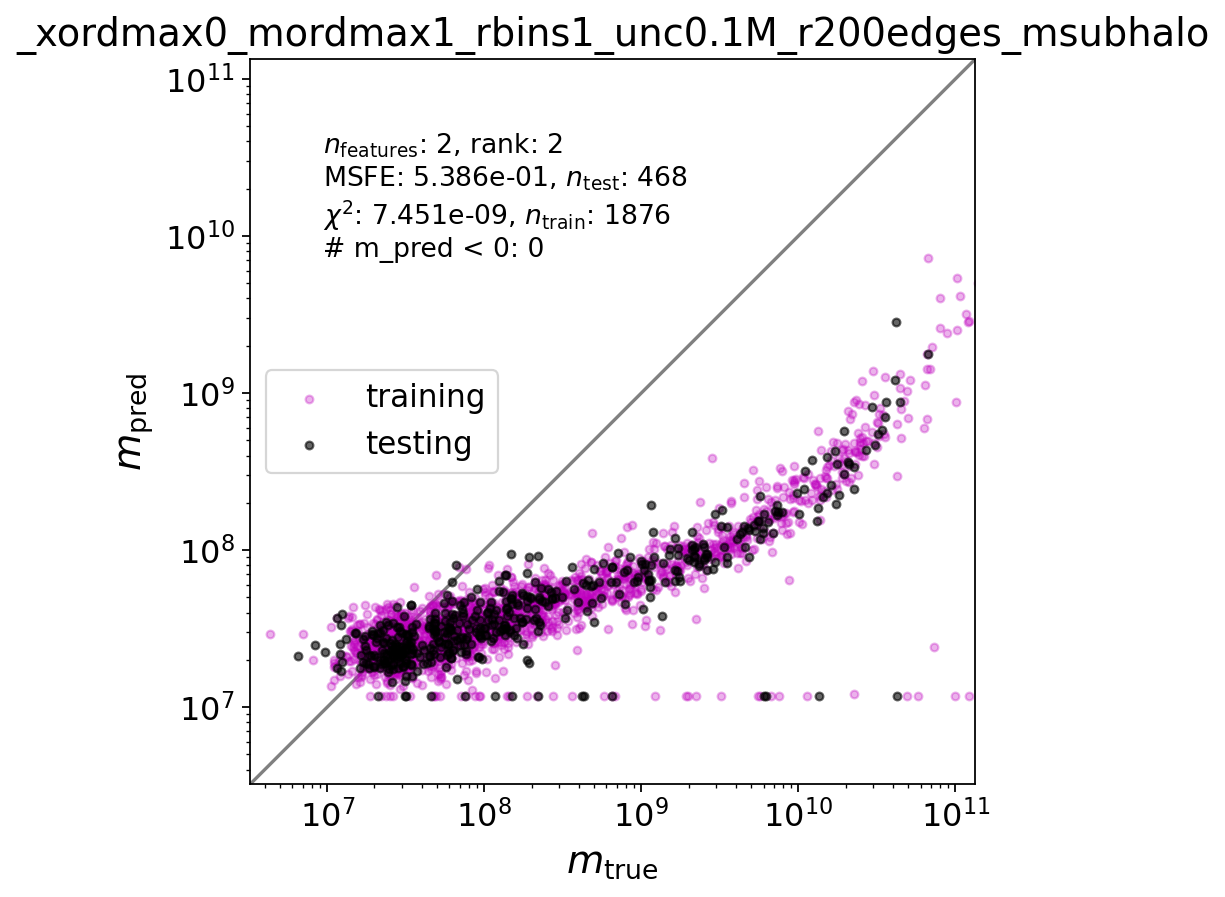

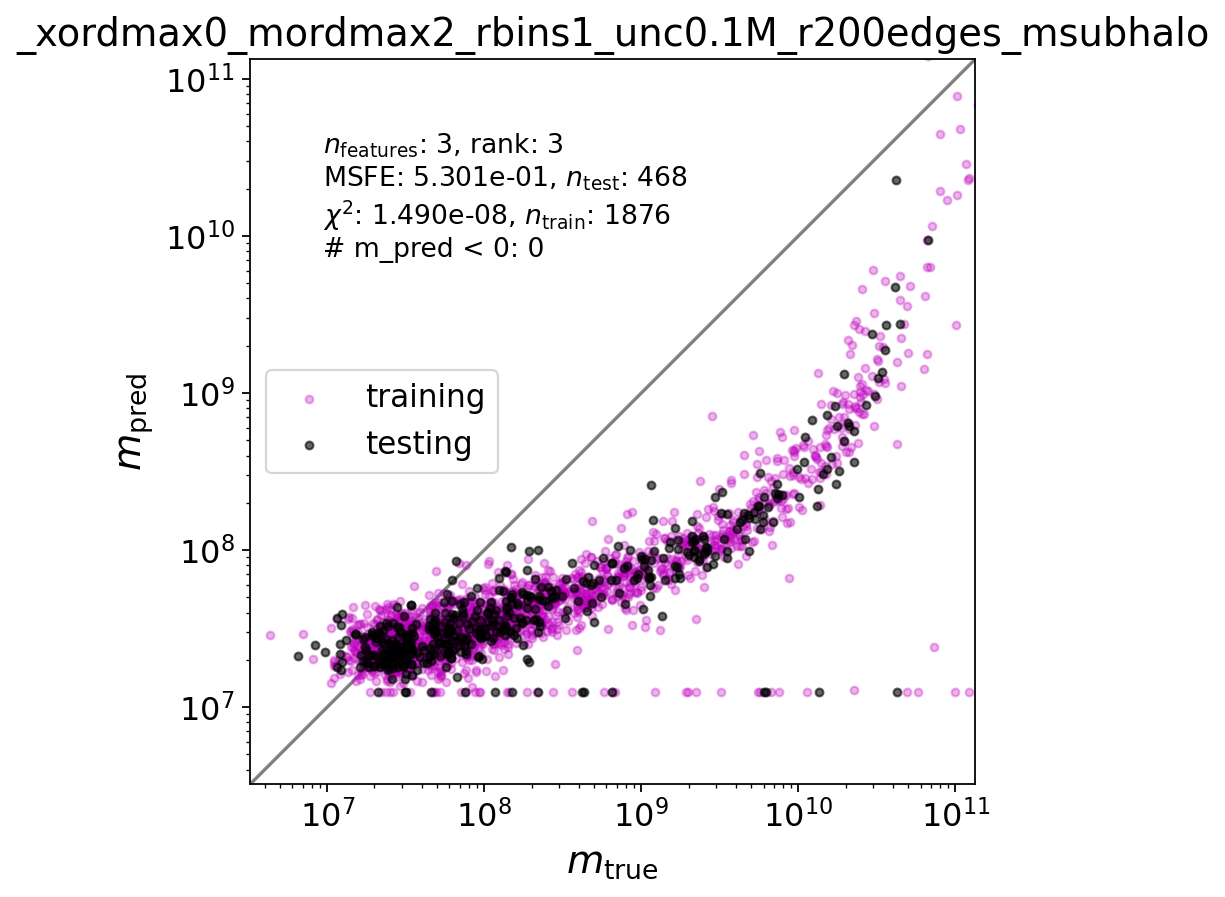

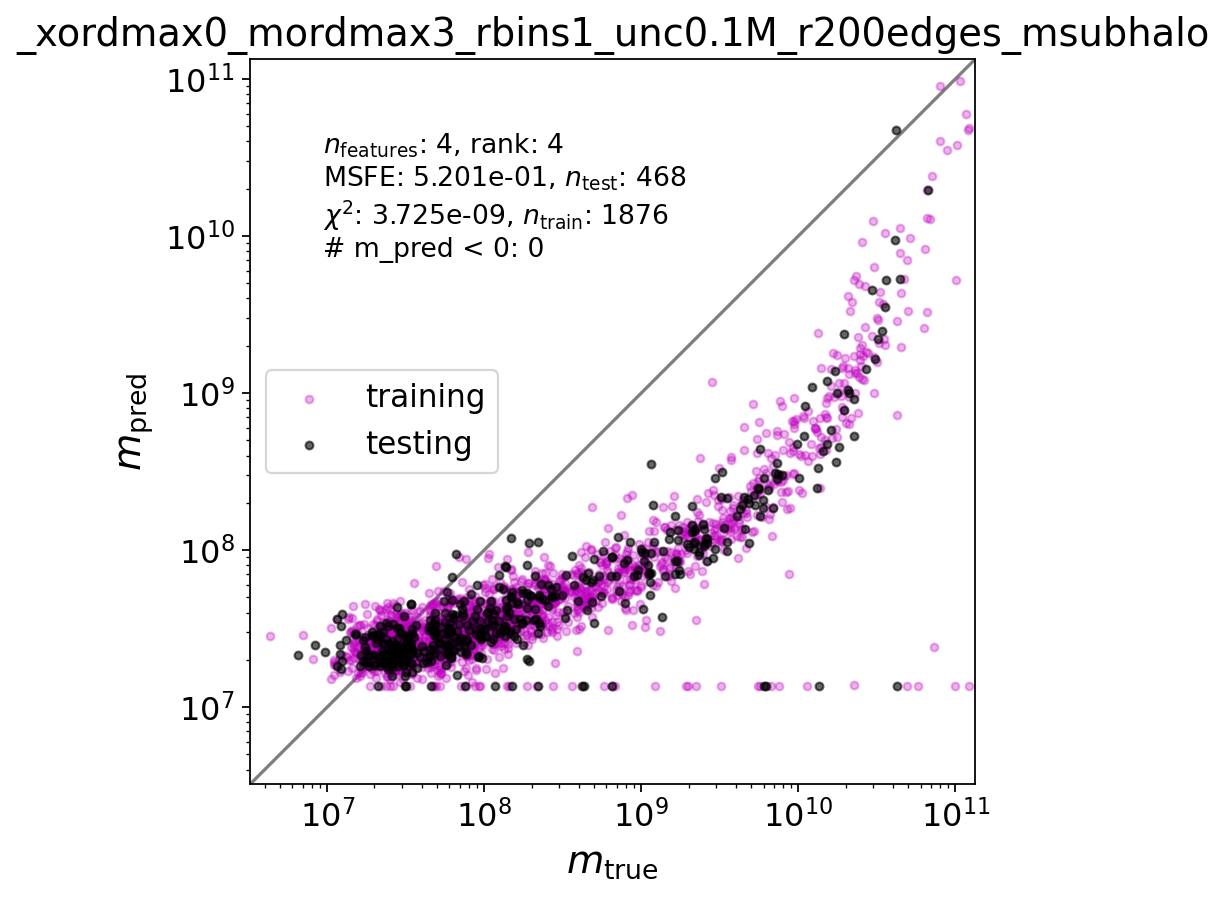

In [14]:
for m_order_max in m_order_max_arr:
    
    # Featurize to order in grid
    featurizer.compute_scalar_features(m_order_max, x_order_max)
    
    # Fit to those features
    fitter = Fitter(featurizer.x_scalar_features, featurizer.y_scalar, 
                featurizer.x_scalar_dicts, uncertainties=uncertainties)
    fitter.split_train_test()
    fitter.scale_and_fit(logy=logy)
    fitter.predict()
    
    # Extract arrays and plot
    save_tag = f'_xordmax{x_order_max}_mordmax{m_order_max}_rbins{len(r_edges)-1}{logy_tag}{unc_tag}{runit_tag}{y_tag}'
    save_fn = f'mass_recovery{save_tag}.pdf'

    y_true = fitter.y_scalar_test*mass_multiplier
    y_pred = fitter.y_scalar_pred*mass_multiplier
    msfe_test = np.mean(((y_pred - y_true)/y_true)**2)

    y_train = fitter.y_scalar_train*mass_multiplier
    y_train_pred = (fitter.x_scalar_train @ fitter.theta_scalar)*mass_multiplier
    chi2_train = fitter.chi2
    #chi2_adjusted = np.sqrt(np.sum(((y_train_pred - y_train)/fitter.uncertainties_train)**2))
    
    plot_pred_vs_true(y_true, y_pred, y_train, y_train_pred, 
                      fitter, msfe_test, chi2_train, save_fn=None)